# Imports & Utilities
In diesem Abschnitt befindet sich Code der zur Vorbereitung für den Hauptteil dient inklusive 
- sämtlichen `import` Statements und
- benutzerdefinierten Funktionen.  

In [ ]:
# utilities
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from wordcloud import WordCloud
from collections import Counter
import numpy as np

# preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

# models
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA

# metrics & model selection
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [ ]:
# install spacy language model, needed for preprocessing
!python -m spacy download de_core_news_sm

In [ ]:
# load spacy language model and define pipeline
nlp = spacy.load("de_core_news_sm")
unwanted_pipes = ["ner", "parser", "tagger"]

In [ ]:
# create custom tokenizer that removes punctuation, spaces and non-alphabetic characters
def spacy_tokenizer(doc):
    with nlp.disable_pipes(*unwanted_pipes):
        return [t for t in nlp(doc) if not t.is_punct and not t.is_space]

In [ ]:
def find_docs_with_character(chars, corpus):
    docs = []
    index = []
    label = []
    for doc in corpus["text"]:
        if any(char in chars for char in doc):
            docs.append(doc)
            index.append(corpus[corpus["text"] == doc].index[0])
            label.append(corpus[corpus["text"] == doc]["label"].values[0])
    return pd.DataFrame({"text": docs, "index": index, "label": label})

In [ ]:
def visualize(col, data):
    print()
    plt.subplot(1, 2, 1)
    sns.boxplot(data, y=col)
    ax1 = plt.gca()
    plt.ylabel(col, labelpad=12.5)

    # plot distribution of classes rotated 90 degrees
    ax = plt.subplot(1, 2, 2)
    ax.set_ylim(ax1.get_ylim())
    sns.kdeplot(data, y=col, hue="label", fill=False, ax=ax)
    plt.xlabel("Density", labelpad=12.5)
    plt.ylabel("", labelpad=12.5)

    plt.show()

In [ ]:
def model_evaluation(y_val, y_pred, labels):
    # print clafficiation report
    print("\t\t\t\tCLASSIFICATIION METRICS\n")
    print(metrics.classification_report(y_val, y_pred, target_names=labels))

    # plot confusion matrix
    conf_mat = confusion_matrix(y_val, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(
        conf_mat,
        annot=True,
        cmap="Blues",
        fmt="d",
        xticklabels=labels,
        yticklabels=labels,
    )
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title("CONFUSION MATRIX\n", size=16)

# Übersicht der Daten
Nachfolgend wird versucht, einen Überblick über die geladenen Daten zu schaffen. Dazu werden zunächst die Daten eingelesen.

In [ ]:
# Read data
train_df = pd.read_parquet("../data/train.parquet")
test_df = pd.read_parquet("../data/test.parquet")

In [ ]:
# Print data shapes
print("Die geladenen Daten verfügen über folgende Dimensionen:")
pd.DataFrame(
    [[train_df.shape[0], train_df.shape[1]], [test_df.shape[0], test_df.shape[1]]],
    columns=["Rows", "Columns"],
    index=["Train", "Test"],
)

Die beiden Datensets werden nun zusammengefügt, damit eine einheitliche übersicht geschaffen werden kann.

In [ ]:
# Combine train and test data for combined eda
corpus = (
    pd.concat([train_df, test_df]).sample(frac=1, random_state=4).reset_index(drop=True)
)

print(
    "Der gesamte Korpus beinhaltet",
    corpus.shape[0],
    "Dokumente und",
    corpus.shape[1],
    "Spalten.",
)

Um einen ersten Eindruck zu erhalten, werden nachfolgend die ersten paar Zeilen ausgegeben. Danach werden Duplikate und fehlende Werte addressiert. 

In [ ]:
corpus.head()

In [ ]:
# Show missing values
print("Fehlende Werte im Korpus:")
print(corpus.isnull().sum())

In [ ]:
# number of duplicates
print("Der Korpus beinhaltet", corpus.duplicated().sum(), "Duplikate.")

In [ ]:
# remove duplicates
corpus = corpus.drop_duplicates()

In [ ]:
print(
    "Nach Entfernung der Duplikaten verfügt der Korpus über die folgende Dimension:",
    corpus.shape,
)

Der Korpus dürfte nun frei von fehlenden Werten und Duplikaten sein. Nachfolgend zeigen diverse Grafiken weitere Aspekte des Datensatzes auf.

In [ ]:
# plot distribution of classes
plt.figure(figsize=(10, 5))
ax = sns.countplot(x="label", data=corpus)
ax.bar_label(ax.containers[0])
plt.title("Verteilung der Labels (n=" + str(corpus.shape[0]) + ")")
plt.show()

Aus dieser Grafik ist zu entnehmen, dass die Verteilung der Klassen sehr gleichmässig ist.

In [ ]:
# plot length of text
plt.figure(figsize=(10, 5))
sns.histplot(corpus["text"].str.len())
plt.title("Verteilung der Länge der Dokumente")
plt.xlabel("Länge des Dokuments")
plt.ylabel("Anzahl der Dokumente")
plt.show()

Der oben gezeigte Plot zeigt die Verteilung der Länge der Dokumente im Form eines Histogramms. Es gibt wenige Dokumente die auffällig lang oder kurz sind und die meisten Dokumente sind zwischen 40 und 80 Zeichen lang.  

In [ ]:
# get list of unique characters in all tokens
unique_chars = list(set([char.lower() for doc in corpus["text"] for char in doc]))

print("Die Anzahl der eindeutigen Zeichen im Korpus ist:", len(unique_chars))

In [ ]:
# count frequency of characters
char_freq = dict(zip(unique_chars, [0] * len(unique_chars)))

for char in unique_chars:
    for doc in corpus["text"]:
        count = char_freq.get(char)
        count += doc.count(char)
        char_freq.update({char: count})

char_freq = pd.DataFrame.from_dict(char_freq, orient="index", columns=["freq"])
char_freq = char_freq.sort_values(by="freq", ascending=False)

# log scale frequency
char_freq["freq"] = char_freq["freq"].apply(lambda x: np.log(x))


# plot frequency of characters as horizontal bar chart
plt.figure(figsize=(10, 20))
sns.barplot(x=char_freq["freq"], y=char_freq.index)
plt.xlabel("log(Häufigkeit)")
plt.title("Häufigkeit der Zeichen (log skaliert)")
plt.show()

Dieser Plot zeigt die Häufigkeit sämtlicher im Korpus enthaltenen Zeichen. Daraus zu entnehmen ist, dass einige unerwartete Sonderzeichen vorhanden sind. Diese werden nachfolgend genauer untersucht.

In [ ]:
# create set of special characters
special_chars = set([char for char in unique_chars if not char.isalnum()])
print("Die Anzahl von speziellen Zeichen im Korpus ist: ", len(special_chars))
special_chars

Diese Liste von Sonderzeichen wurde generiert, indem nicht alphanumerische Charaktere von der Liste der eindeutig vorkommenden Zeichen exkludiert wurden. 
Welcher Funktion diese Sonderzeichen dienen und welche Implikationen diese für das weitere Vorgehen haben können wird nachfolgend untersucht. 

In [ ]:
print("Die Anzahl von Dokumenten welche das", "`.`", "Zeichen beinhalten:")
find_docs_with_character(["."], corpus)["label"].value_counts()

In [ ]:
print("Die Anzahl von Dokumenten welche das", "`?`", "Zeichen beinhalten:")
find_docs_with_character(["?"], corpus)["label"].value_counts()

In [ ]:
print("Die Anzahl von Dokumenten welche das", "`!`", "Zeichen beinhalten:")
find_docs_with_character(["!"], corpus)["label"].value_counts()

Die Verteilung der Satzzeichen entspricht unserer Erwartung. Sie können einen ungewollten Bias in das Modell übertragen, sodass jedes Dokument mit einem `?` zum Beispiel direkt als `question` klassifiziert wird. Deshalb entfernen wir bei der Tokenisierung sämtliche Satzzeichen. 

In [ ]:
print("Die Dokumente, welche das Zeichen" , "`-`", "beinhalten:")
find_docs_with_character(["-"], corpus)

Es scheint, als würde das Zeichen `-` konsequent genutzt werden, um eigenstehende Wörter zu einem längeren und spezifischeren Wort zu verbinden. Nachfolgend ein kurzer Test, um zu prüfen, wie der SpaCy Tokeniser solche Wörter tokenisiert. 

In [ ]:
spacy_tokenizer(corpus["text"][16])

Mit `-` verbundene Wörter werden als ein Token wahrgenommen, was für unseren Anwendungsbereich das gewünschte Verhalten ist.

In [ ]:
print("Die Anzahl von Dokumenten welche das", '\'"\'', "Zeichen beinhalten:")
find_docs_with_character(['"'], corpus)["label"].value_counts()

In [ ]:
print("Die Dokumente, welche das Zeichen" , '\'"\'', "beinhalten:")
find_docs_with_character(['"'], corpus)

In [ ]:
spacy_tokenizer(corpus["text"][1318])

Die `"` Zeichen werden vom SpaCy Tokeniser entfernt. Häufig werden in diesem Kontext Named Entities in Hochkommas gesetzt. Named Entity Recognition nutzen wir in diesem Kontext nicht, weshalb die Zeichen ohne Weiteres entfernt werden können. 

In [ ]:
print("Die Anzahl von Dokumenten welche das", "`/`", "Zeichen beinhalten:")
find_docs_with_character(["/"], corpus)

In [ ]:
spacy_tokenizer(corpus["text"][81])

Das `/` Zeichen wird hier genutzt, um eine Auswahl von zutreffenden Wörtern zu gruppieren. Der SpaCy Tokeniser entfernt das Zeichen und teilt die Wörter in einzelne Tokens auf, was dem gewünschten Verhalten in unserem Fall entspricht.

In [ ]:
print("Die Anzahl von Dokumenten welche das", "`#`", "Zeichen beinhalten:")
find_docs_with_character(["#"], corpus)

In [ ]:
spacy_tokenizer(corpus["text"][416])

Das Zeichen `#` kommt im Korpus nur einmal vor. SpaCy's Tokenizer trennt in diesem Fall die verschiedenen Hashtags nicht in einzelne Tokens, weshalb wir nachfolgend um alle `#` weitere Leerzeichen einfügen.

In [ ]:
# insert space after # in strings of documents in corpus
corpus["text"] = corpus["text"].apply(lambda x: x.replace("#", " # "))

In [ ]:
spacy_tokenizer(corpus["text"][416])

In [ ]:
print("Die Anzahl von Dokumenten welche das", "`%`", "Zeichen beinhalten:")
find_docs_with_character(["%"], corpus)

In [ ]:
spacy_tokenizer(corpus["text"][1199])

In [ ]:
print("Die Anzahl von Dokumenten welche das", "`&`", "Zeichen beinhalten:")
find_docs_with_character(["&"], corpus)

In [ ]:
spacy_tokenizer(corpus["text"][1099])

In [ ]:
print("Die Anzahl von Dokumenten welche das", "`:`", "Zeichen beinhalten:")
find_docs_with_character([":"], corpus)

In [ ]:
spacy_tokenizer(corpus["text"][836])

In [ ]:
print("Die Anzahl von Dokumenten welche das", "`’`", "Zeichen beinhalten:")
find_docs_with_character(["’"], corpus)

In [ ]:
spacy_tokenizer(corpus["text"][745])

In [ ]:
print("Die Anzahl von Dokumenten welche das", "`'`", "Zeichen beinhalten:")
find_docs_with_character(["'"], corpus)

In [ ]:
spacy_tokenizer(corpus["text"][382])

In [ ]:
spacy_tokenizer(corpus["text"][741])

Diverse Dokumente beinhalten eines der folgenden Zeichen: `%`, `& `, `:`, `’`, `'`. Keines dieser Zeichen wird vom Tokenizer speziell beachtet, was in unserem Fall in Ordnung ist.

Numbers?

In [ ]:
# find docs with numbers
print("Die Dokumente, welche Zahlen beinhalten:")
find_docs_with_character(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], corpus)

In [ ]:
spacy_tokenizer(corpus["text"][13])

Der SpaCy Tokenizer betrachtet Zahlen als Token, was in unserem Fall dem gewünschten Verhalten entspricht. 

# Spellchecker
Die im Korpus vorhandenen Wörter können Schreibfehler, Slang und Abkürzungen beinhalten. Den Text weiter zu normalisieren unterlassen wir anbetracht dessen, dass die Vektorisierung mittels TF-IDF nicht sehr gut mit OOV Wörtern umgehen kann. 

# Tokenisierung

In [ ]:
# tokenisation (remove punctuation and spaces)
tokens = corpus["text"].apply(spacy_tokenizer)

In [ ]:
token_df = pd.DataFrame()
token_df["doc"] = corpus["text"]
token_df["tokens"] = tokens
token_df["word count"] = token_df["tokens"].apply(len)
token_df["doc length"] = corpus["text"].apply(len)
token_df["mean word length"] = token_df["doc length"] / token_df["word count"]
token_df["label"] = corpus["label"]
token_df.head()

In [ ]:
print("Durchschnittliche Anzahl Wörter pro Dokument: ", token_df["word count"].mean())
print("Durchschnittliche Anzahl Zeichen pro Dokument: ", token_df["doc length"].mean())
print(
    "Durchschnittliche Anzahl Zeichen pro Wort: ", token_df["mean word length"].mean()
)

In [ ]:
features = token_df.columns.tolist()[2:5]
for feature in features:
    visualize(feature, token_df)

Die oben dargestellten plots zeigen die folgenden Verteilungen:
- Anzahl Wörter pro Dokument
- Länge pro Dokument (Anzahl Zeichen)
- Durchschnittliche Länge der Wörter pro Dokument

Zu sehen ist, dass es bei der Länge der Dokumente sowie der durchschnittlichen Länge der Wörter pro Dokument einige Outliers gibt. Zudem erkennbar ist, dass Texte des Labels `concern` im Durchschnitt kürzere Wörter und kürzere Dokumente aufweisen. `question`-Texte sind eher länger als die anderen. 

Nachfolgend schauen wir uns die Verteilung der Outlier genauer an.

In [ ]:
# calculate outliers for doc length using iqr
dl_iqr = token_df["doc length"].quantile(0.75) - token_df["doc length"].quantile(0.25)
dl_upper = token_df["doc length"].quantile(0.75) + 1.5 * dl_iqr

token_df[token_df["doc length"] > dl_upper].value_counts("label")


Die meisten Outlier bezüglich Länge der Dokumente sind vom Label `harm`.

In [ ]:
# calculate outliers for doc length using iqr
mwl_iqr = token_df["mean word length"].quantile(0.75) - token_df["mean word length"].quantile(0.25)
mwl_upper = token_df["mean word length"].quantile(0.75) + 1.5 * mwl_iqr

token_df[token_df["mean word length"] > mwl_upper].value_counts("label")

Die meisten Outlier bezüglich durchschnittlicher Länge der im Dokument genutzten Wörter sind ebenfalls vom label `harm`, wobei `question` auch einige Outlier aufweist.

Als nächstes schauen wir uns die generierten Tokens genauer an. 

In [ ]:
# get unique tokens
tokens_flat = list([token for doc in tokens for token in doc])
vocabulary = list(set([token.lower_ for token in tokens_flat]))

# count unique tokens
print("Die Anzahl von eindeutigen Tokens ist: ", len(vocabulary))

In [ ]:
lowercase_tokens = [token.lower_ for doc in tokens for token in doc]

# get most common tokens
print("Die meistvorkommenden Tokens sind: ")

pd.DataFrame(
    Counter(lowercase_tokens).most_common(20), columns=["Token", "Frequency"]
).set_index("Token")

In [ ]:
# create wordcloud
wordcloud = WordCloud(
    width=800, height=400, background_color="white", max_words=200
).generate(" ".join(lowercase_tokens))

# show wordcloud
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
# group tokens by label and get most common tokens
grouped_tokens = token_df.groupby("label")["tokens"].apply(list)
grouped_tokens = grouped_tokens.apply(
    lambda x: [token.lower_ for doc in x for token in doc]
)
grouped_tokens

In [ ]:
most_frequent_harm = pd.DataFrame(
    Counter(grouped_tokens["harm"]).most_common(20),
    columns=["Token", "Frequency"],
).set_index("Token")

# plot most common tokens for other
plt.figure(figsize=(10, 5))
sns.barplot(x=most_frequent_harm["Frequency"], y=most_frequent_harm.index)
plt.title("Meistvorkommende Tokens des Labels harm")
plt.show()

In [ ]:
most_frequent_question = pd.DataFrame(
    Counter(grouped_tokens["question"]).most_common(20),
    columns=["Token", "Frequency"],
).set_index("Token")

# plot most common tokens for other
plt.figure(figsize=(10, 5))
sns.barplot(x=most_frequent_question["Frequency"], y=most_frequent_question.index)
plt.title("Meistvorkommende Tokens des Labels question")
plt.show()

In [ ]:
most_frequent_concern = pd.DataFrame(
    Counter(grouped_tokens["concern"]).most_common(20),
    columns=["Token", "Frequency"],
).set_index("Token")

# plot most common tokens for other
plt.figure(figsize=(10, 5))
sns.barplot(x=most_frequent_concern["Frequency"], y=most_frequent_concern.index)
plt.title("Meistvorkommende Tokens des Labels concern")
plt.show()

In [ ]:
# spacy stopword list
stopwords = spacy.lang.de.stop_words.STOP_WORDS

# check if stopwords are in top 20 most common tokens
print("Stopwörter, welche in den top 20 Tokens vorkommen: ")
for token in stopwords:
    if token in [token for token, freq in Counter(lowercase_tokens).most_common(20)]:
        print(token)

Wenn nun im Preprocessing die Stopwörter mit dem SpaCy Tokeniser entfernt werden, würden zum Beispiel auch der Token `ich` entfernt werden, welcher unverhältnismässig oft bei Texten des Labels `concern` vorkommt. Das könnte die Performance von klassischen Machine Learning Modellen negativ beeinflussen. Ob das tatsächlich so ist, wird  im nächsten Abschnitt erkundet.

# Preprocessing

In [ ]:
y_train = train_df.label
y_val = test_df.label

Nachfolgend wird der Tokenizer angewendet, welcher das Modell `de_core_news_sm` für den tokenising Prozess verwendet. Das NER-Tagging, der Parser und der POS-Tagger wurde deaktiviert, da diese Tags auf die Berechnung der TF-IDF Vektoren keinen Einfluss haben. 

Die Standard Pipeline von SpaCy sieht wiefolgt aus:

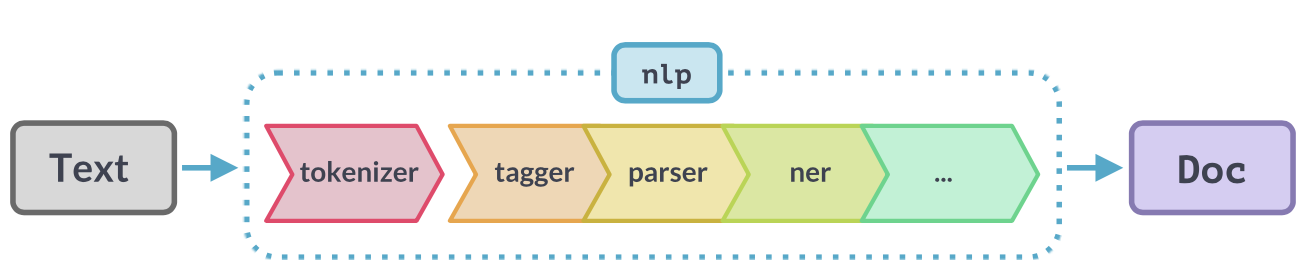

Nach der Deaktivierung der Tagger bleibt also nur der Tokenizer Step übrig. Nachdem die Tokens generiert wurden, werden die Satzzeichen und Leerzeichen entfernt und die restlichen Tokens an den TfidfVectorizer weitergegeben.

In [ ]:
# calculate tf-idf vectors
vectorizer = TfidfVectorizer(tokenizer=spacy_tokenizer)

X_train = vectorizer.fit_transform(train_df.text).toarray()
X_val = vectorizer.transform(test_df.text).toarray()

Zum Vergleich wird nachfolgend ein Tokenizer erstellt, welcher anstelle vom standard Token das jeweilige Lemma widergibt, um so die Grösse des Vokabulars zu vermindern.

In [ ]:
def lemma_tokenizer(doc):
    with nlp.disable_pipes(*unwanted_pipes):
        return [t.lemma_ for t in nlp(doc) if not t.is_punct and not t.is_space]

In [ ]:
# calculate tf-idf vectors
lemma_vectorizer = TfidfVectorizer(tokenizer=lemma_tokenizer)

X_train_lemma = lemma_vectorizer.fit_transform(train_df.text).toarray()
X_val_lemma = lemma_vectorizer.transform(test_df.text).toarray()

In [ ]:
X_train.shape

In [ ]:
X_train_lemma.shape

Das Resultat vom Tokenizer, welcher die Lemmas erzeugt, ist rund 3 mal kleiner dimensioniert als die standard Tokens. Wie sich das auf die Performance von Klassifikationsmodellen beeinflusst, wird anschliessend überprüft.

# Classification Models

## Modelle
Nachfolgend wird eine Auswahl von Klassifikationsmodellen der `sklearn` Library verwendet, um ein geeignetes Modell für die Aufgabenstellung zu finden. Die folgende Auswahl wurde definiert:
- `RandomForestClassifier`
- `LinearSVC`
- `MultinomialNB`
- `HistGradientBoostingClassifier`
- `GaussianNB`
- `LinearDiscriminantAnalysis`
- `QuadraticDiscriminantAnalysis`

Zum Vergleich der Modelle wird ein 5-fold cross validation durchgeführt, um anschliessend die Metriken vergleichen zu können.

In [ ]:
# define models to compare
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    HistGradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train, y_train, scoring="accuracy", cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=["model_name", "fold_idx", "accuracy"])

In [ ]:
mean_accuracy = cv_df.groupby("model_name").accuracy.mean()
std_accuracy = cv_df.groupby("model_name").accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis=1, ignore_index=True)
acc.columns = ["Mean Accuracy", "Standard deviation"]
acc

Die Performance sämtlicher Modelle basierend auf den standard Tokens ist nicht hervorragend. 

In [ ]:
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(
        model, X_train_lemma, y_train, scoring="accuracy", cv=CV
    )
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df_lemma = pd.DataFrame(entries, columns=["model_name", "fold_idx", "accuracy"])

In [ ]:
mean_accuracy = cv_df_lemma.groupby("model_name").accuracy.mean()
std_accuracy = cv_df_lemma.groupby("model_name").accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis=1, ignore_index=True)
acc.columns = ["Mean Accuracy", "Standard deviation"]
acc

Die Performance wird durch den Lemma Tokenizer drastisch verbessert. Was passiert, wenn die Stopwörter entfernt werden, um die Dimension der Inputmatrix weiter zu reduzieren?

In [ ]:
# remove stopwords
def lemma_tokenizer_no_stop(doc):
    with nlp.disable_pipes(*unwanted_pipes):
        return [t.lemma_ for t in nlp(doc) if not t.is_punct and not t.is_space and not t.is_stop]
lemma_vectorizer_no_stop = TfidfVectorizer(tokenizer=lemma_tokenizer_no_stop)

X_train_wo_sw = lemma_vectorizer_no_stop.fit_transform(train_df.text).toarray()
X_val_wo_sw = lemma_vectorizer_no_stop.transform(test_df.text).toarray()

In [ ]:
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(
        model, X_train_wo_sw, y_train, scoring="accuracy", cv=CV
    )
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df_wo_sw = pd.DataFrame(entries, columns=["model_name", "fold_idx", "accuracy"])

In [ ]:
mean_accuracy = cv_df_wo_sw.groupby("model_name").accuracy.mean()
std_accuracy = cv_df_wo_sw.groupby("model_name").accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis=1, ignore_index=True)
acc.columns = ["Mean Accuracy", "Standard deviation"]
acc

Allgemein sinkt die Performance durch die Entfernung der Stopwörter, weshalb nachfolgend mit dem Lemma Tokenizer gearbeitet wird.

In [ ]:
X_train = X_train_lemma
X_val = X_val_lemma

vectorizer = lemma_vectorizer

In [ ]:
X_train.shape

# Modell Evaluation und Verfeinerung
Das Modell mit der höchsten Accuracy war bisher das `LinearSVC` Modell. Im nachfolgenden Abschnitt wird geprüft, ob mit Feature Selection das Modell noch weiter verbessert werden kann und das finale Modell evaluiert.

In [ ]:
# fit LinearSVC model to predict y values of X_val
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

In [ ]:
# evaluate model
model_evaluation(y_val, y_pred, ["other", "question", "concern"])

Oberhalb dargestellt ist der Performance Report und die Konfusionsmatrix des `LinearSVC` Modells, trainiert auf den TF-IDF Werten der Lemma-Tokens. Es werden bereits sehr wenige Texte falsch klassifiziert, doch kann diese Performance mit Feature Selection noch weiter verbessert werden?

In [ ]:
# pca to reduce dimensionality
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_lemma)
X_val_pca = pca.transform(X_val_lemma)

In [ ]:
X_train_pca.shape

In [ ]:
model.fit(X_train_pca, y_train)
y_pred = model.predict(X_val_pca)

In [ ]:
model_evaluation(y_val, y_pred, train_df.label.unique())

Mit PCA kann die Dimension der Inputmatrix weiter reduziert werden, ohne im Durschnitt an Performance einbüssen zu müssen. 

In [ ]:
# nmf to reduce dimensionality
nmf = NMF(n_components=813)
X_train_nmf = nmf.fit_transform(X_train_lemma)
X_val_nmf = nmf.transform(X_val_lemma)

X_train_nmf.shape

In [ ]:
model.fit(X_train_nmf, y_train)
y_pred = model.predict(X_val_nmf)

In [ ]:
# evaluate model
model_evaluation(y_val, y_pred, train_df.label.unique())

Eine weitere Möglichkeit die Dimensionen zu reduzieren ist `NMF`, welche hier genutzt wurde. Die Anzahl zu erreichender Dimensionen wurde basierend auf dem PCA Resultat gewählt und oben zu sehen ist, dass diese Methode in einer schlechteren Performance resultiert. 
Daher lässt sich mit den hier verglichenen Modellen und Preprocessing Methoden konkludieren, dass die folgende Pipeline das beste Modell zur Verfügung stellt:
- Tokenisierung mit Lemma
- Satz- und Leerzeichen entfernen
- TF-IDF Vektor berechnen
- PCA zur Dimensionsreduzierung
- LinearSVC Modell trainieren

Nachfolgend werden die Texte der falsch vorhergesagten Labels aufgelistet.

In [ ]:
# show wrong predictions
test_df["predicted"] = y_pred
test_df[test_df.label != test_df.predicted].head(17)

Mit der nachfolgenden Funktion kann ein beliebiger Text dem Modell zur Klassifizierung übergeben werden.

In [ ]:
# inference
def predict(text):
    text = vectorizer.transform([text]).toarray()
    text = pca.transform(text)
    return model.predict(text)

In [ ]:
predict("Was ist heute für ein Tag?")

# Export des Modells

In [ ]:
with open("models/linearSVC.pkl", "wb") as f:
    pickle.dump(model, f)